In [1]:
import svm_data
import SVMclass
import importlib
importlib.reload(SVMclass)
importlib.reload(svm_data)
import numpy as np

In [2]:
# Define species to use and load training data from file
archean_species = np.array(['CO2','CH4','CO','N2'])
archean_train_data, archean_train_labels, train_refs = svm_data.load_training_data('./SVM mixing ratio inputs - Archean Earth + false positives.csv', archean_species, header_row=0)

In [3]:
# Initialize and train SVM

# See SVMclass for full list of hyperparameters
archean_svm = SVMclass.SVMclass(use_ensemble=True, n_ensemble_models=2, log_scale=True, random_state=np.random.randint(0, 10000))

# This will automatically split training data into a train and test set and store results. Test set is used to validate the fit.
archean_svm.train(archean_train_data, archean_train_labels,  test_size=0.2, n_bootstrap=2)

Training ensemble models: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


Predicting on training and test sets...


In [4]:
# This method prints out some metrics to see how well the SVM is doing on given data. If no data is passed it uses the stored test set.
archean_svm.detailed_performance_metrics()

Using test data...
Detailed Performance Metrics:
------------------------------
True Positive Rate (Sensitivity): 1.000
True Negative Rate (Specificity): 1.000
False Positive Rate: 0.000
False Negative Rate: 0.000
Precision: 1.000
F1 Score: 1.000


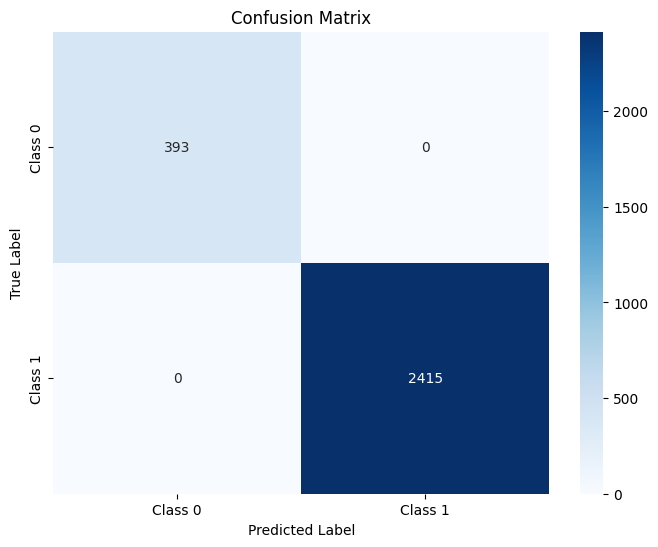

In [5]:
# Function for plotting the confusioin matrix. Label = 1 means biotic. Predicted label = 1 if the assigned SVM probability is > 0.5.
# Again if no data is passed then the trianing set it used.
archean_svm.plot_confusion_matrix()

/home/sam/Research/Exo/svm/SVMclass.py:848: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjusted rect to leave more room at top


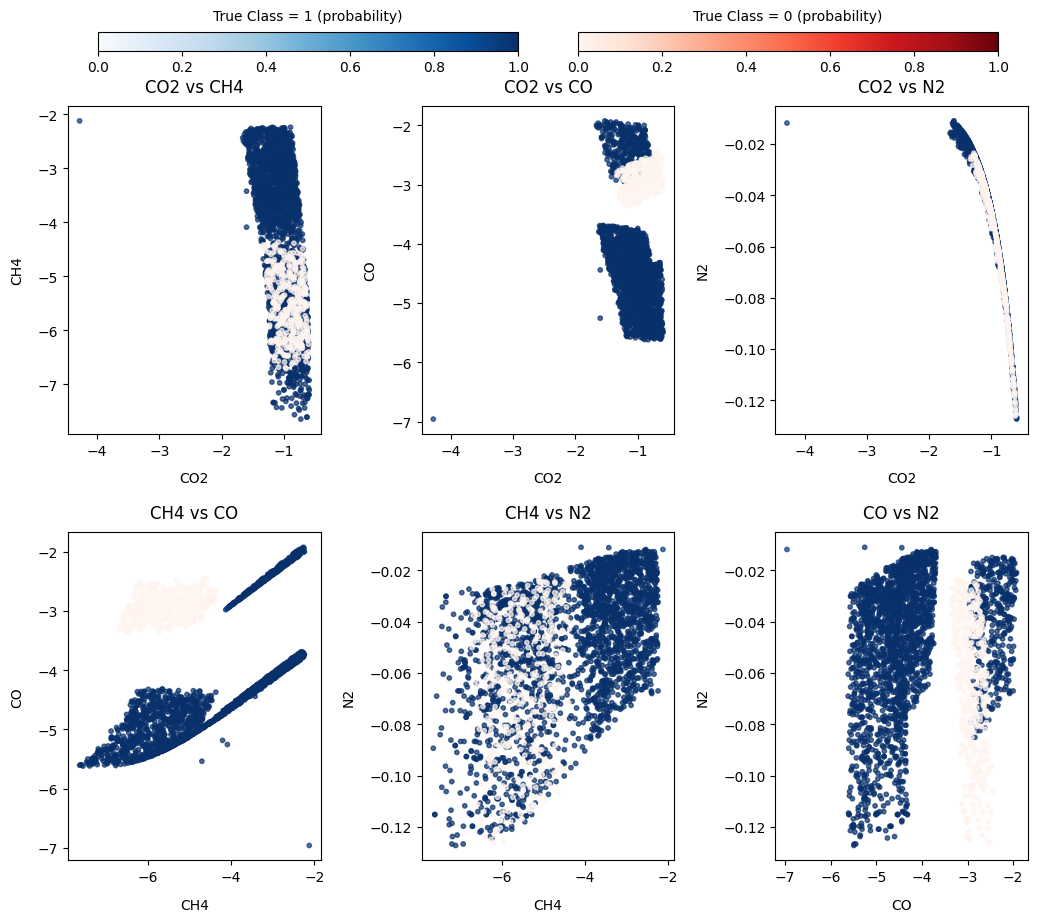

In [6]:
# Function for plotting the data distributions and the SVM predictions against feature pairs. Again if no data is passed then the test set it used.
archean_svm.plot_svm_pairwise(feature_names=archean_species, point_size=10, scale='linear')

In [7]:
# The SVM implementation supports a few different types of predictions:
# In the below examples we use the training data as input but in real use it would be some new test data.

# This method is the default scikit-learn prediction function. 
# Uses a single SVM (no model esembling) and returns the raw SVM output (not calibrated as a probability).
# Input is a vector of single data points and output is a prediction for each point. Also returns the input after it has been scaled for use by the SVM.
x_scaled, predictions = archean_svm.predict(X=archean_train_data[:100])

# While SVM outputs are by default not probabilities (really just a distance from the decision boundary), these can be calibrated to quasi probabilities using 
# a logistic regression called Platt scaling. This method is the same as above but returns the calibrated probability.
x_scaled, prob_predictions = archean_svm.predict_proba(X=archean_train_data[:100])

# If the SVM is initialized with use_ensemble=True, an ensemble of SVMs will be trained on bootstrapped samples of the training data. This allows a quanitification of 
# the model uncertainty due to the limited training data. The below method will return probability predictions and confidence intervals.
# the output is a dict for each entry with the fiducial prediction and an upper/lower interval.
x_scaled, ensemble_prob_predictions = archean_svm.predict_proba_ensemble(X=archean_train_data[:100], n_bootstrap=100, confidence_level=0.95)

# If our test case is not a single point but instead a distribution (e.g. feature distributions from an rfast retrieval or a data point with uncertainties),
# the below method will accept a vector of data points sampled from that distribution and return a single prediction for the whole distribution with confidence intervals.
# The confidence interval due to the distribution (essentially measurement uncertinty) is estimated again with bootstrapped samples of the data. If use_ensemble=True, 
# the model uncertainties are also estimated and both uncertainties are combined in quadrature. 
x_scaled, individual_point_probs, distribution_prediction = archean_svm.distribution_predict(X=archean_train_data[:100], n_bootstrap=100, confidence_level=0.95)

In [ ]:
# Below we use the SVM distribution_predict to evalutate the lieklyhood of life in an rfast retrieval of a simulated Archean Earth. There are several helper methods
# for loading this data, comparing results across retrievals of the same spectrum with different parameters (e.g. SNR, wavelength cutoff), and plotting. 

# First, load the test rfast data. This will be done with the svm_data.SVMDatasetManager object which allows us to load and compare differnt rfast retrievals.

# number of samples to use
nsamps = 10000

# mc params of the retrieval. see rfast's .scr file
mc_params = {
    'nburn': 100000,
    'thin': 100,
    'nstep': 200000,
    'nwalkers': 100
}

# Define the configuration of the files. The files should be in one directory which is passed separately. Any set of optional params can be specified and then used
# later for plotting (e.g. temperature, pressure, etc.). The rpars file is used to determine which columns of the data correspond to each species. Alternatively, a list 
# of lists containing the column indices for each file can be passed, in which case each list should be in the same order as the species list passed to the SVM initially.
archean_high_config = {
    'data_files': ['snr40_2um.h5', 'snr20_2um.h5', 'snr10_2um.h5', 'snr40_1um.h5', 'snr20_1um.h5', 'snr10_1um.h5'],
    'rpars_files': ['rfast_rpars.txt'] * 6,  # Same file repeated
    'snr': [40, 20, 10, 40, 20, 10],
    'wavelength': ['2um', '2um', '2um', '1um', '1um', '1um']
}

# First two params are name of the dataset and its base directory. fill_species and ptype are params of the retrieval, see svm_data.extract_rfast_data_from_file for more info.
archean_svm.add_dataset('archean_high', './data/high_co2/', archean_high_config, nsamps, archean_species, mc_params, fill_species='N2', ptype='log_vmr')

# We can add another dataset to compare
archean_low_config = {
    'data_files': ['snr40_2um.h5', 'snr20_2um.h5', 'snr10_2um.h5', 'snr40_1um.h5', 'snr20_1um.h5', 'snr10_1um.h5'],
    'rpars_files': ['rfast_rpars.txt'] * 6,  # Same file repeated
    'snr': [40, 20, 10, 40, 20, 10],
    'wavelength': ['2um', '2um', '2um', '1um', '1um', '1um']
}

archean_svm.add_dataset('archean_low', './data/low_co2/', archean_low_config, nsamps, archean_species, mc_params, fill_species='N2', ptype='log_vmr')

In [9]:
# Predict on the datasets using the distribution_predict function
archean_svm.predict_on_datasets()

Generating predictions for dataset: archean_high


Processing files: 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


Generating predictions for dataset: archean_low


Processing files: 100%|██████████| 6/6 [00:01<00:00,  5.77it/s]


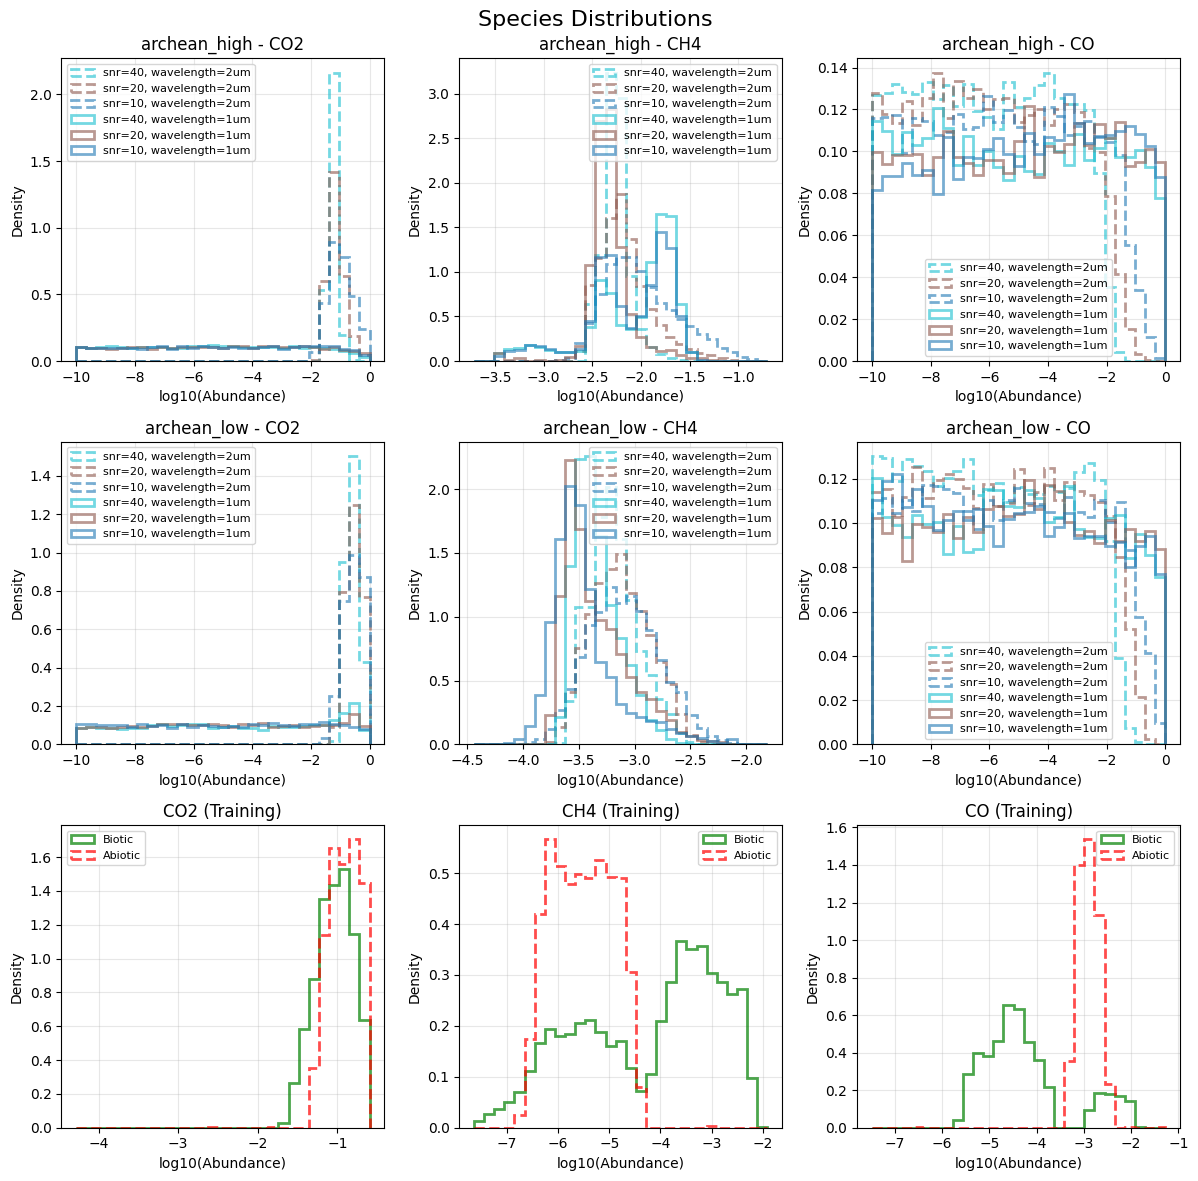

In [10]:
# This function plots the distributions of selected species in the data against selected parameters of the data. Also optionally shows the training distribution.
archean_svm.plot_species_distributions_multi(dataset_names=['archean_high','archean_low'], species=archean_species, species_idx=[0,1,2], 
                                       color_param='snr', linestyle_param='wavelength',
                                       training_data=archean_train_data, training_truth=archean_train_labels, 
                                       title_prefix="Species Distributions",
                                       color_map=None, linestyle_map=None)

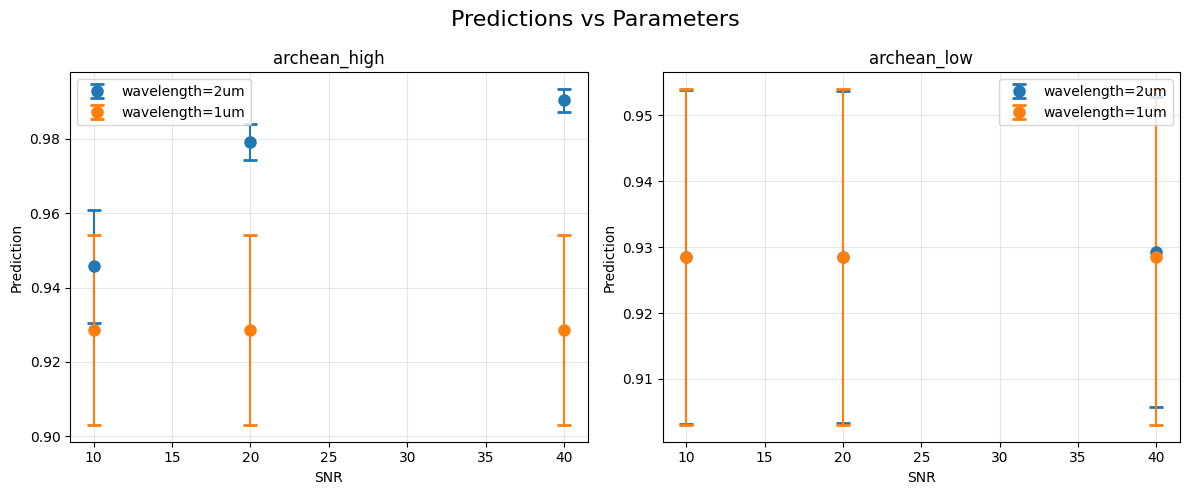

In [11]:
# Plot the predictions on the distributions are a function of the params for different datasets
archean_svm.plot_predictions_vs_parameters(dataset_names=['archean_high','archean_low'], param_name='snr', 
                                     group_by='wavelength', title="Predictions vs Parameters")